# Meta-Feature evaluation

# Imports

In [2]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_paac, calculate_aac
from subpred.eval import (
    get_independent_test_set,
    optimize_hyperparams,
    preprocess_pandas,
    models_quick_compare,
    get_confusion_matrix,
    get_classification_report,
    full_test,
    quick_test
)
from subpred.util import get_feature_score
from subpred.plots import labeled_clustermap, pca_plot_2d, pca_plot_3d
from subpred.pssm import calculate_pssms_notebook

import pandas as pd

# Dataset

In [3]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "integrate",
    outliers= ['P76773', 'Q47706', 'P02943', 'P75733', 'P69856', 'P64550'],
    verbose = True,
    tax_ids_filter = [83333],
    output_log = "../logs/ecoli_amino_sugar_dataset.log",
    sequence_clustering=70
)

cd-hit: clustered 99 sequences into 98 clusters at threshold 70


# Feature generation

In [4]:
labels = df.keywords_transport
labels.value_counts()

Amino-acid transport    51
Sugar transport         47
Name: keywords_transport, dtype: int64

In [5]:
df_aac = calculate_aac(df.sequence)
df_paac = calculate_paac(df.sequence)
df_pssm = calculate_pssms_notebook(df.sequence)

In [7]:
df_combined = pd.concat([
    df_aac, df_paac, df_pssm
], axis=1)
df_combined

,A,C,D,E,F,G,H,I,K,L,...,VL_90_3,VK_90_3,VM_90_3,VF_90_3,VP_90_3,VS_90_3,VT_90_3,VW_90_3,VY_90_3,VV_90_3
Uniprot,,,,,,,,,,,,,,,,,,,,,
P69801,0.150376,0.007519,0.030075,0.022556,0.037594,0.093985,0.015038,0.120301,0.011278,0.101504,...,0.496933,0.487730,0.503067,0.558282,0.450920,0.472393,0.475460,0.490798,0.592025,0.481595
P36672,0.093023,0.012685,0.023256,0.023256,0.044397,0.103594,0.016913,0.105708,0.029598,0.120507,...,0.436330,0.421348,0.436330,0.556180,0.370787,0.464419,0.423221,0.503745,0.644195,0.436330
P56580,0.097179,0.012539,0.040752,0.034483,0.034483,0.122257,0.015674,0.100313,0.040752,0.100313,...,0.410876,0.389728,0.407855,0.504532,0.371601,0.413897,0.404834,0.444109,0.555891,0.398792
P0AA47,0.106195,0.006637,0.028761,0.026549,0.077434,0.070796,0.013274,0.075221,0.030973,0.110619,...,0.464052,0.416122,0.472767,0.640523,0.350763,0.420479,0.424837,0.570806,0.838780,0.461874
P08722,0.100800,0.012800,0.038400,0.033600,0.062400,0.100800,0.016000,0.092800,0.035200,0.108800,...,0.443131,0.437223,0.454948,0.514032,0.410635,0.438700,0.440177,0.472674,0.584934,0.447563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P19642,0.090566,0.013208,0.026415,0.024528,0.066038,0.105660,0.024528,0.084906,0.032075,0.120755,...,0.480253,0.461295,0.481833,0.532385,0.454976,0.464455,0.464455,0.519747,0.593997,0.473934
P0AAD4,0.116625,0.007444,0.019851,0.012407,0.064516,0.106700,0.019851,0.062035,0.017370,0.171216,...,0.525449,0.494012,0.519461,0.622754,0.479042,0.510479,0.517964,0.574850,0.718563,0.508982
P23173,0.084337,0.016867,0.024096,0.012048,0.093976,0.096386,0.014458,0.113253,0.040964,0.120482,...,0.546237,0.464516,0.548387,0.608602,0.455914,0.516129,0.511828,0.531183,0.752688,0.529032


## Plots

First, let's create a plot of the three feature types, and see how they look together in a dataframe:

({'aac': 'cyan', 'paac': 'magenta', 'pssm': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7f90aa4beeb0>)

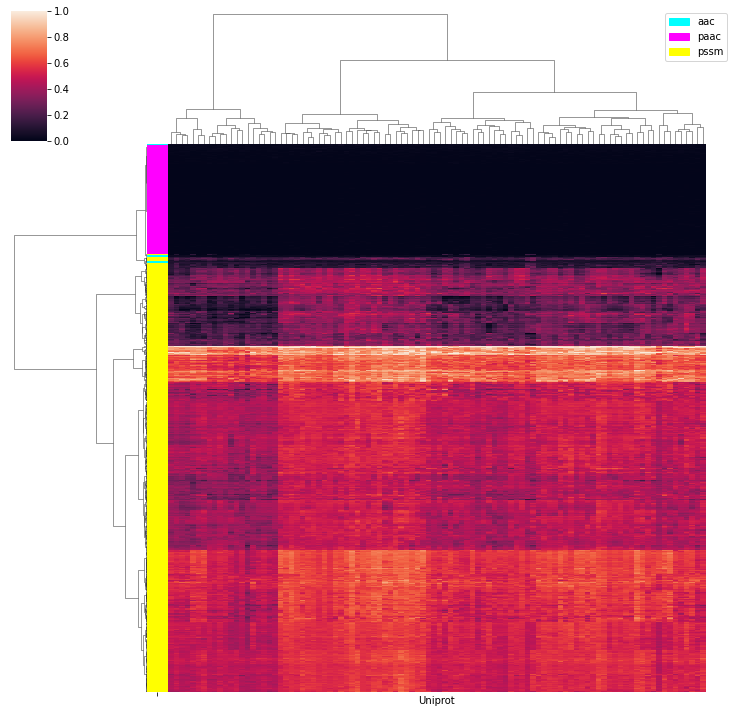

In [8]:
import re

aac = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY]$")
paac = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY]$")
pssm = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY]_\d\d_\d$")

def get_feature_type(feature_name):
    if paac.match(feature_name):
        return "paac"
    elif aac.match(feature_name):
        return "aac"
    elif pssm.match(feature_name):
        return "pssm"
    else:
        raise ValueError("unknown feature type!")

labeled_clustermap(df_combined.T, df_combined.columns.to_series().apply(get_feature_type))

PAAC and AAC values are a lot lower, since they are percentages, while PSSM values are scaled to [0,1]. The scaling was done along the feature axis, to avoid information sharing. What does the data look like when we also scale PAAC and AAC to [0,1]?

({'aac': 'cyan', 'paac': 'magenta', 'pssm': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7f90904bfeb0>)

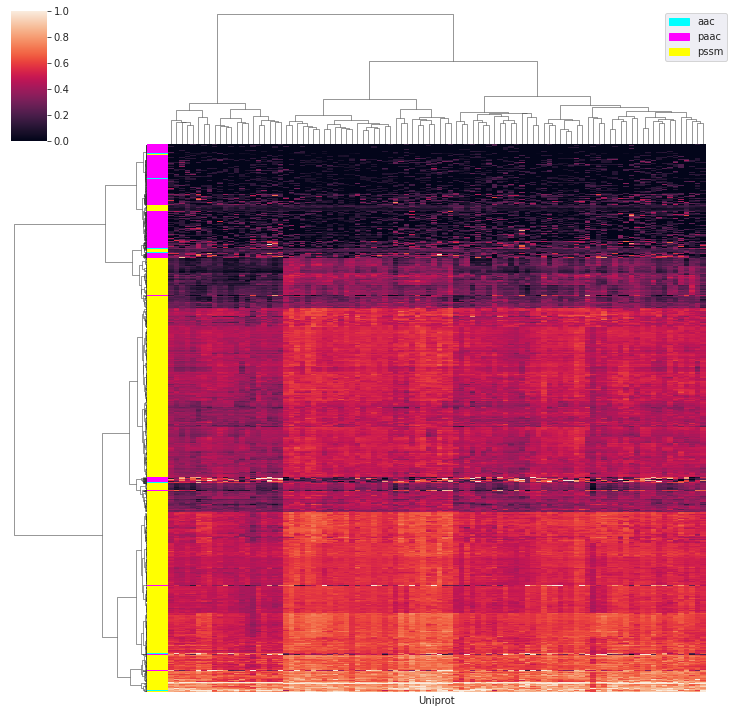

In [25]:
from sklearn.preprocessing import minmax_scale

def min_max_samples(df_feature):
    return pd.DataFrame(data=minmax_scale(df_feature, axis=1), index=df_feature.index, columns = df_feature.columns)

df_combined_minmax = pd.concat([
    min_max_samples(df_aac), min_max_samples(df_paac), min_max_samples(df_pssm)
], axis=1)
# df_combined_minmax = pd.DataFrame(data=minmax_scale(df_combined, axis=1), index=df_combined.index, columns = df_combined.columns)
labeled_clustermap(df_combined_minmax.T, df_combined_minmax.columns.to_series().apply(get_feature_type))
# df_combined_minmax#.iloc[0].max()

The PCA plot shows this even better:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

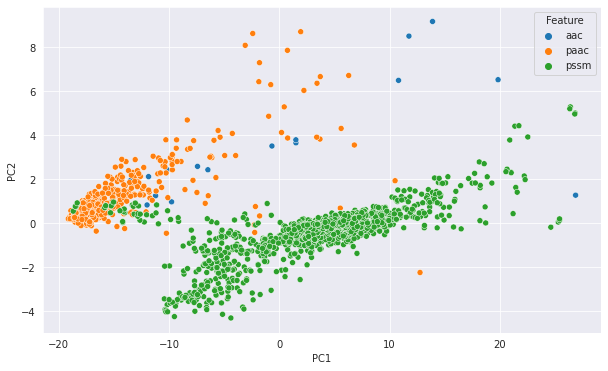

In [38]:
pca_plot_2d(df_combined_minmax.T, df_combined_minmax.T.index.to_series().apply(get_feature_type).rename("Feature"))

What does the data look like when standardizing along the feature axis? In the model, the parameters for this will be derived from the training set and applied to the test set, to avoid data leakage.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f908db3bd00>)

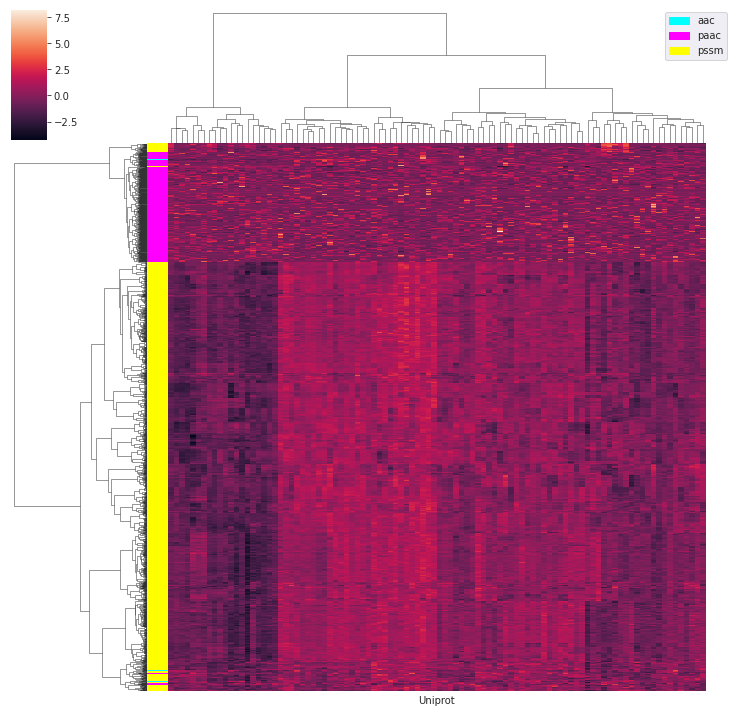

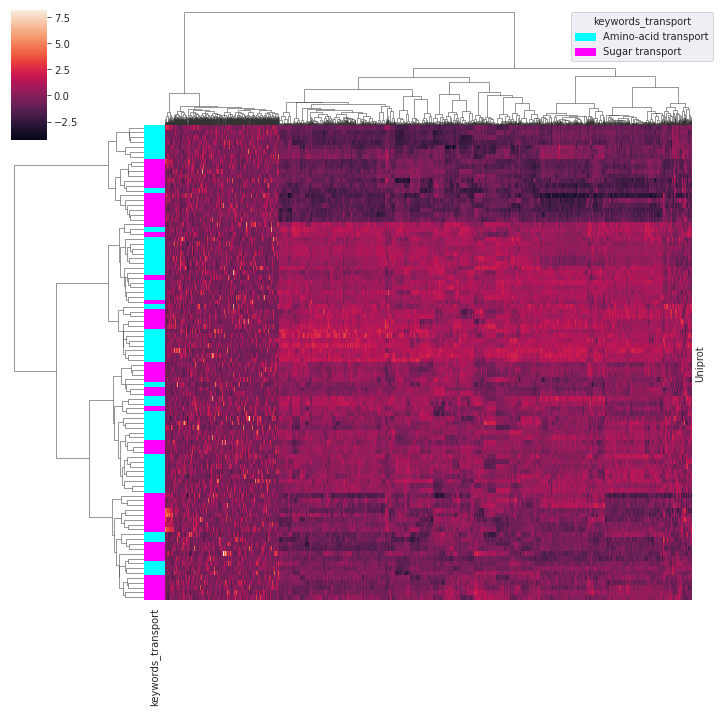

In [42]:
from sklearn.preprocessing import scale

df_combined_std = pd.DataFrame(
    data=scale(df_combined), index=df_combined.index, columns=df_combined.columns
)
labeled_clustermap(
    df_combined_std.T, df_combined.columns.to_series().apply(get_feature_type)
)
labeled_clustermap(
    df_combined_std, df.keywords_transport
)

The composition data looks a bit noisier, however this could also be caused by the fact that more PSSM features exist, and therefore have a higher impact on the h-clustering algorithm. The second plot shows that the two sample clusters do not correspond to the classes. 

The PCA plot of the standardized features also looks good. There is a distinct separation between the feature types:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

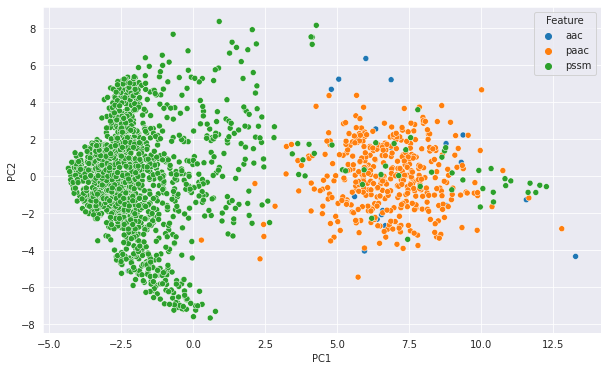

In [43]:
pca_plot_2d(df_combined_std.T, df_combined_std.T.index.to_series().apply(get_feature_type).rename("Feature"))

## Independent test set

In [44]:
X, y, feature_names, sample_names = preprocess_pandas(
    df_combined, labels, return_names=True
)
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
) = get_independent_test_set(X, y, sample_names=sample_names, test_size=0.2)



## Model comparison

In [45]:
models_quick_compare(X_train, y_train)

,0,1,2,3,4,mean,std
est,,,,,,,
GaussianNB(),0.733,0.619,0.746,0.583,0.661,0.668,0.071
KNeighborsClassifier(),0.733,0.812,0.875,0.598,0.796,0.763,0.105
"LinearSVC(class_weight='balanced', max_iter=1000000.0)",1.000,0.937,0.937,0.661,0.866,0.880,0.132
LinearSVC(max_iter=1000000.0),1.000,0.937,0.937,0.661,0.866,0.880,0.132
RandomForestClassifier(),0.654,0.686,0.812,0.722,0.661,0.707,0.064
RandomForestClassifier(class_weight='balanced'),0.564,0.686,0.875,0.796,0.732,0.731,0.117
SGDClassifier(),0.935,0.937,0.812,0.533,0.661,0.776,0.177
SVC(),0.792,0.746,0.875,0.796,0.661,0.774,0.079
SVC(class_weight='balanced'),0.733,0.746,0.875,0.796,0.661,0.762,0.080


## Feature importance

How many top 100 features come from each feature type?

In [49]:
top50 = get_feature_score(df_combined, labels, remove_zero_variance=True).sort_values(
    "Normalized score", ascending=False
).head(50)
top50.Feature.apply(get_feature_type).value_counts()

pssm    50
Name: Feature, dtype: int64

In [55]:
top50[top50.Feature.apply(get_feature_type) == "pssm"].head(10)


,Feature,Normalized score,Measure
609,IL_50_1,0.002320,Feature importance (f_classif)
872,NF_50_3,0.002246,Feature importance (f_classif)
719,SA_50_1,0.002162,Feature importance (f_classif)
863,NC_50_3,0.002125,Feature importance (f_classif)
873,NP_50_3,0.002111,Feature importance (f_classif)
734,SS_50_1,0.002099,Feature importance (f_classif)
476,NW_50_1,0.002074,Feature importance (f_classif)
472,NF_50_1,0.002066,Feature importance (f_classif)
869,NL_50_3,0.002062,Feature importance (f_classif)
877,NY_50_3,0.002052,Feature importance (f_classif)


There seems to be a disproportionate amount of Asparagine (N) among the top-performing features:

In [56]:
top50[top50.Feature.apply(get_feature_type) == "pssm"].Feature.apply(lambda x: [x[0], x[1]]).explode().value_counts()

N    32
S    10
L     8
F     6
H     6
W     5
A     5
Y     4
R     4
I     4
C     4
P     3
T     3
V     2
G     2
M     1
Q     1
Name: Feature, dtype: int64

## Parameter tuning

#### Custom transformer


Whole dataset, linear svm

In [60]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction=None,
    C=[0.1, 1, 10],
)
best_estimator_svc = gsearch


{'linearsvc__C': 1, 'linearsvc__class_weight': 'balanced', 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0}
0.881


Good results, but relatively high value for C. With the custom transformer:

In [61]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction=None,
    C=[0.1, 1, 10],
    feature_transformer="pssm",
    feature_names=feature_names,
)
best_estimator_svc = gsearch


{'linearsvc__C': 1, 'linearsvc__class_weight': 'balanced', 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0, 'pssmselector__iterations': 'all', 'pssmselector__uniref_threshold': 'all'}
0.881


Same results as before. Maybe RBF allows for a lower value of C?

In [63]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction=None,
    C=[1, 10, 100],
)
best_estimator_svc = gsearch

{'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.795


No, and the results become slightly worse. 

In [64]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction=None,
    C=[0.1, 1, 10],
    feature_transformer="pssm",
    feature_names=feature_names,
)
best_estimator_svc = gsearch

{'pssmselector__iterations': 1, 'pssmselector__uniref_threshold': 'all', 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.815


The PSSM selector improves the result a bit.

## Dimensionality reduction

Trying only in steps of 20, to reduce runtime.

In [65]:
gsearch = optimize_hyperparams(
    X_train, y_train, kernel="linear", dim_reduction="kbest", C=[1, 10, 100], select_k_steps=20, remove_zero_var=True
)
best_estimator_svc_kbest = gsearch

{'linearsvc__C': 1, 'linearsvc__class_weight': 'balanced', 'linearsvc__dual': True, 'linearsvc__max_iter': 100000000.0, 'selectkbest__k': 1281}
0.893


In [66]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction="pca",
    # feature_transformer="pssm",
    # feature_names=feature_names,
    # C=[0.1, 0.01, 0.001],
    # gamma=[0.1, 0.01, 0.001],
)


{'linearsvc__C': 0.1, 'linearsvc__class_weight': None, 'linearsvc__dual': True, 'linearsvc__max_iter': 100000000.0, 'pca__n_components': 0.99}
0.895


PCA seems to perform the best and is faster, how about the RBF kernel?

In [71]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    # feature_transformer="pssm",
    # feature_names=feature_names,
    C=[1, 10,100],
    gamma=["scale"],
)

{'pca__n_components': 0.99, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.907


This time, the PSSM transformer does not make a difference, and we get the same score:

In [72]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    feature_transformer="pssm",
    feature_names=feature_names,
    C=[1, 0.1, 10],
    # gamma=["scale", 0.1, 0.01, 0.001],
)
best_estimator_svc_pca = gsearch

{'pca__n_components': 0.99, 'pssmselector__iterations': 'all', 'pssmselector__uniref_threshold': 'all', 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.907


## Validation

As for the training set, PCA returns better validation results as well, by classifying one more transporter correctly.


### Kbest

In [73]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_kbest, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,9,1
Sugar transport,1,9


In [74]:
get_classification_report(X_test, y_test, best_estimator_svc_kbest, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,0.9,0.9,0.9,10
Sugar transport,0.9,0.9,0.9,10
macro avg,0.9,0.9,0.9,20
weighted avg,0.9,0.9,0.9,20


### PCA

In [75]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_pca, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,10,0
Sugar transport,1,9


In [76]:
get_classification_report(X_test, y_test, best_estimator_svc_pca, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,0.909,1.00,0.952,10
Sugar transport,1.000,0.90,0.947,10
macro avg,0.955,0.95,0.950,20
weighted avg,0.955,0.95,0.950,20


## Estimating validation variance

How much did the result depend on choosing the training and test sets?

Mean and standard deviation for randomly selected training and validation sets.

In [77]:
df_scores, df_params = full_test(
    df_combined,
    labels,
    dim_reduction="pca",
    kernel="rbf",
    repetitions=10,
    feature_transformer="pssm",
)
df_scores_gr = df_scores.groupby(["label", "dataset"], as_index=False)
print("Mean F1")
display(df_scores_gr.mean().pivot(index="label", columns="dataset", values="F1 score"))
print("Sdev F1")
display(df_scores_gr.std().pivot(index="label", columns="dataset", values="F1 score"))
print("Parameters")
display(df_params)

Mean F1


dataset,test,train
label,,
Amino-acid transport,0.8844,0.8852
Sugar transport,0.8838,0.8699


Sdev F1


dataset,test,train
label,,
Amino-acid transport,0.091304,0.030608
Sugar transport,0.087276,0.032102


Parameters


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.95,0.95,0.83,0.87,0.91,0.98,0.98,0.81,0.97,0.8
pssmselector__iterations,all,all,all,all,all,all,3,all,all,all
pssmselector__uniref_threshold,50,all,all,90,50,all,all,90,50,all
svc__C,1,10,1,1,1,1,1,10,10,1
svc__class_weight,balanced,balanced,balanced,balanced,None,balanced,balanced,balanced,balanced,None
svc__gamma,0.01,0.01,scale,0.1,scale,scale,scale,scale,scale,scale


### Effect of removing active transporters

In the PSSM notebook, we were able to improve the results drastically by removing active transporters from the dataset. Is this also the case for the META-feature?

In [78]:
df_no_active = df[~df.tcdb_class.str.startswith("3")]
df_aac_no_active = df_aac.loc[df_no_active.index]
df_paac_no_active = df_paac.loc[df_no_active.index]
df_pssm_no_active = df_pssm.loc[df_no_active.index]

df_combined_no_active = pd.concat([
    df_aac_no_active, df_paac_no_active, df_pssm_no_active
], axis=1)

labels_no_active = df_no_active.keywords_transport

In [79]:
df_scores, df_params = full_test(
    df_combined_no_active,
    labels_no_active,
    dim_reduction="pca",
    kernel="rbf",
    repetitions=10,
    feature_transformer="pssm",
)
df_scores_gr = df_scores.groupby(["label", "dataset"], as_index=False)
print("Mean F1")
display(df_scores_gr.mean().pivot(index="label", columns="dataset", values="F1 score"))
print("Sdev F1")
display(df_scores_gr.std().pivot(index="label", columns="dataset", values="F1 score"))
print("Parameters")
display(df_params)

Mean F1


dataset,test,train
label,,
Amino-acid transport,0.8088,0.9015
Sugar transport,0.8051,0.8944


Sdev F1


dataset,test,train
label,,
Amino-acid transport,0.116646,0.029867
Sugar transport,0.118195,0.028508


Parameters


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.83,0.87,0.92,0.97,0.8,0.8,0.86,0.81,0.99,0.93
pssmselector__iterations,all,all,all,all,all,all,all,all,all,1
pssmselector__uniref_threshold,all,50,all,all,90,90,90,all,all,all
svc__C,0.1,1,10,0.1,10,1,1,10,1,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__gamma,0.01,0.01,0.1,0.1,scale,0.1,0.1,scale,0.01,0.1


In case of the META-feature, removing the active transporters actually lowers the average scores. We should use the entire dataset, or just the PSSM feature alone. This result matches the observations for PAAC and AAC, where removing the active transporters did not make a difference. 